# Visualising Uncertainty (Example)

NB: *This notebook uses code from [ShuaiGuo16's GitHub repository](https://github.com/ShuaiGuo16/Hypothetical_Outcome_Plots), which contains a series of examples of Hypothetical Outcome Plots.*

## Hypothetical Outcome Plots

In machine learning, the predictive models we train are assumed to represent (to varying degrees of accuracy) some process in the world.
The trained model, therefore, is a best guess at what is sometimes called the underlying "generative model".
That is, the hidden process in the world that *generates* the data that is fed into the ML algorithm.

But the resulting model is only one possible model in a potentially vast set (or, model space).
As such, there will remain some uncertainty about how well the trained model captures the underlying data generating process.

This is where data visualisations like 'hypothetical outcome plots' come in.
They make explicit some of the other models as a way of displaying the uncertainty inherent in the training process.

The following code creates a simple example of a hypothetical outcome plot.

### Importing Packages

This first code block is responsible for importing the necessary software packages that Python needs to generate the data, the models, and the animation.

In [34]:
# import necessary packages (using shortcodes, e.g. numpy > np)

import numpy as np
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

### Generating Data

Next, we generate some random data that will be used to train our model.
A simple plot shows the training data.

In [35]:
# Sample locations
X_train = np.array([[0,0.04,0.06,0.07,0.1,0.12,0.15,\
                     0.18,0.2,0.24,0.31,0.35,0.38,0.4,0.44,\
                     0.5,0.52,0.55,0.62,0.67,0.73,0.8,0.9,0.96,1]]).T
# Generate clean data
y_clean = (X_train*6-2)**2*np.sin(X_train*12-4)

# Generate noisy data
noise_std = 1
np.random.seed(42)
noise = np.random.normal(loc=0.0, scale=noise_std, size=(X_train.shape[0],1))
y_train = y_clean + noise

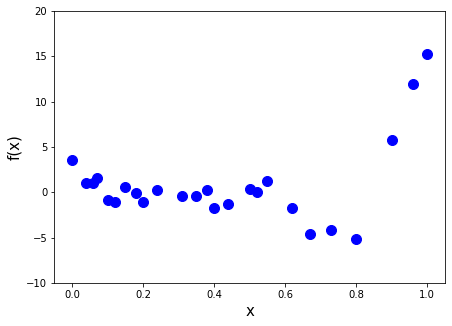

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

plt.show()

### Training our Model

The next step is to train a model that attempts to predict our original data generating process.

In [37]:
# Train Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=0.4, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
X_test = np.arange(0, 1.01, 0.01)
y_pred, pred_cov = model.predict(X_test.reshape((-1, 1)), return_cov=True)
y_pred = np.ravel(y_pred)

# Prediction standard deviation
pred_std = np.sqrt(np.diag(pred_cov))

The following plot shows our training data, the model's prediction and the credibility interval (i.e. the uncertainty of the predictions of the trained model).

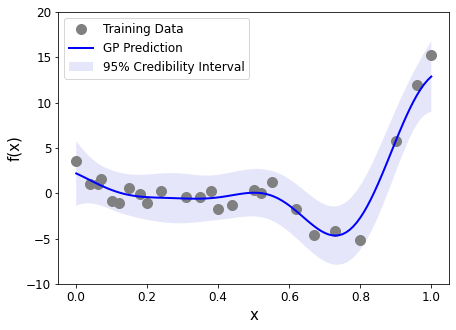

In [38]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_train,y_train,'o',color=(0.5,0.5,0.5),markerfacecolor=(0.5,0.5,0.5),markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.fill_between(X_test, y_pred-1.96*pred_std, y_pred+1.96*pred_std,facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12})
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

plt.show()

This credibility interval serves a purpose; it displays the possible space in which other predictions could fall. But how informative is this interval, and is it the best option available to us?
Let's see if we can do better.

### Animating Uncertainty
The next code block builds our Hypothetical Outcome Plot.
As you can see from the animation at the bottom, the shape of the possible curves varies quite significantly within the credibility interval. 
This information is not as clear in the original static image, but is made more explicit when we switch to a more dynamic form of communicating uncertainty.

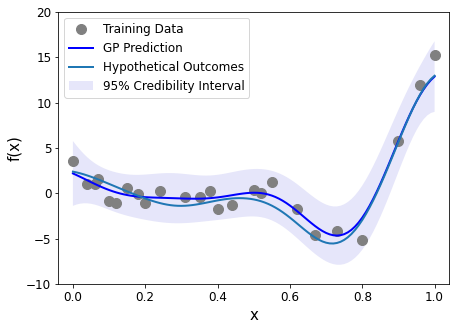

In [40]:
# Generate realizations of GP prediction
sample_num = 10
realizations = np.random.multivariate_normal(mean=y_pred, cov=pred_cov, size=sample_num)

fig, ax = plt.subplots(figsize=(7,5))
ax.set(xlim=(-0.04, 1.04), ylim=(-10, 20))
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)

# Non-changing part
ax.plot(X_train,y_train,'o',color=(0.5,0.5,0.5),markerfacecolor=(0.5,0.5,0.5),markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.fill_between(X_test, y_pred-1.96*pred_std, y_pred+1.96*pred_std,facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)

# Changing part
line, = ax.plot([], [], lw=2, label='Hypothetical Outcomes')


def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = X_test
    y = realizations[i-1,:]
    line.set_data(x, y)
    ax.legend(loc="upper left",prop={'size': 12})
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sample_num, interval=1000, blit=True)

HTML(anim.to_html5_video())